In [177]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from pathlib import Path
from dotenv import load_dotenv

import os

from scipy import ndimage

from utils.yolo import get_teeth_ROI
from utils.edge import gum_jaw_separation, vertical_separation, get_rotation_angle, consecutive

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

% matplotlib inline

# TODO 008140 008225 tooth missing


In [178]:
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')
tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'
}

data_dir = '..' / Path(os.getenv('DATASET_DIR'))


YOLOv5  torch 1.12.0 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)



requirements: D:\Users\douli\anaconda3\envs\dentist-CV-main\Lib\site-packages\yolov5\requirements.txt not found, check failed.


Fusing layers... 
Model summary: 270 layers, 7041205 parameters, 0 gradients
Adding AutoShape... 


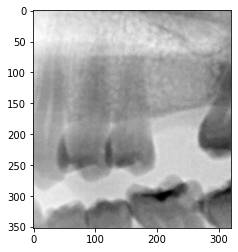

In [179]:
image_number = 1
image_names = list(data_dir.glob('*008225.jpg'))

image_name = image_names[0]
filename = image_name.stem

results = model(image_name)
teeth_roi = get_teeth_ROI(results)
teeth_roi_images = teeth_roi['images'][filename]
teeth_roi_split_teeth = teeth_roi['split_teeth']

target_roi = teeth_roi_images[2]
target_roi_image = target_roi['image']
flag = target_roi['flag']
tooth_position = tooth_position_dict[target_roi['number']]
im_g = cv2.cvtColor(target_roi_image, cv2.COLOR_RGBA2GRAY)
im_g_shape = np.array(np.array(im_g.shape)[[1, 0]])

plt.imshow(1 - im_g, cmap='gray')
plt.show()


Rotate image to make tooth vertical

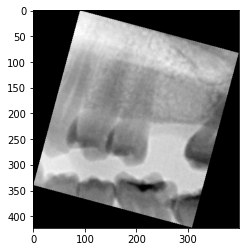

In [180]:
source = im_g

theta = get_rotation_angle(source, flag=flag, tooth_position=tooth_position)
source_rotated = ndimage.rotate(source, theta, reshape=True, cval=255)

gum_sep_line, jaw_sep_line, hor_valleys, hor = gum_jaw_separation(source_rotated, flag=flag)

plt.imshow(1 - source_rotated, cmap='gray')
plt.show()


Zoom-in the crowns and discard the roots

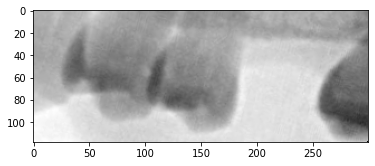

In [181]:
height, width = source.shape
phi = np.radians(abs(theta))
opposite = np.sin(phi) * width
adjacent = np.cos(phi) * height

if flag == 'upper':
    source_roi = source_rotated[gum_sep_line:jaw_sep_line, :]
    y1 = gum_sep_line
    y2 = jaw_sep_line
elif flag == 'lower':
    source_roi = source_rotated[jaw_sep_line:gum_sep_line, :]
    y1 = jaw_sep_line
    y2 = gum_sep_line
else:
    raise ValueError(f'flag only accept upper or lower but get {flag}.')

if theta > 0:
    left_padding = round((y2 - opposite) * np.tan(phi))
    right_padding = round((adjacent - y1) * np.tan(phi))
    source_roi = source_roi[:, left_padding:-right_padding]
elif theta < 0:
    left_padding = round((adjacent - y1) * np.tan(phi))
    right_padding = round((y2 - opposite) * np.tan(phi))
    source_roi = source_roi[:, left_padding:-right_padding]

plt.imshow(1 - source_roi, cmap='gray')
plt.show()


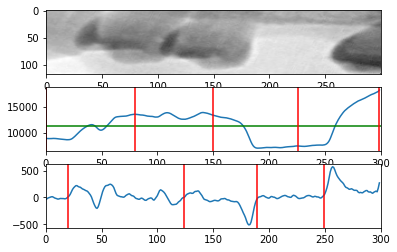

In [185]:
tooth_type = 'incisor' if tooth_position == 'middle' else 'molar'
window_position, valleys, ver, ver_slope = vertical_separation(source_roi, flag=flag, tooth_type=tooth_type,
                                                               angle=theta)

# Missing tooth detection
ver_mean = ver.mean()
tooth_missing_region = []
for i in range(ver.shape[0] - 1):
    is_derivative_smooth = abs(ver_slope[i] - ver_slope[i + 1]) < 45
    curve_under_mean = ver[i] < ver_mean

    if is_derivative_smooth and curve_under_mean:
        tooth_missing_region.append(i)
tooth_missing_region = consecutive(tooth_missing_region)
tooth_missing_region = [(i[0], i[-1]) for i in tooth_missing_region if len(i) > 60]

# Delete redundant valley
for i in tooth_missing_region:
    valley_between_missing_tooth = ((i[0] < valleys) & (valleys < i[1]))
    valley_near_missing_tooth = np.logical_or(np.abs(valleys - i[0]) < 20, np.abs(valleys - i[1]) < 20)
    valley_need_delete = np.logical_or(valley_between_missing_tooth, valley_near_missing_tooth)

    valleys = valleys[~valley_need_delete]
    valleys = np.append(valleys, i)

bounding_number = len(valleys) - 1

# Plot area
fig, axs = plt.subplots(3, 1)
axs[0].imshow(1 - source_roi, aspect='auto', cmap='gray')

height, width = source_roi.shape

axs[1].xaxis.set_ticks_position('bottom')
axs[1].set_xlim(xmin=0, xmax=width)
axs[1].plot(ver)
axs[1].axhline(y=ver_mean, color='g')
for p in window_position:
    axs[1].axvline(x=p, color='r')

axs[2].xaxis.set_ticks_position('bottom')
axs[2].set_xlim(xmin=0, xmax=width)
axs[2].plot(ver_slope)
for p in valleys:
    axs[2].axvline(x=p, color='r')

plt.show()


In [183]:
a = tooth_missing_region[0]
np.logical_or(np.abs(valleys - a[0]) < 20, np.abs(valleys - a[1]) < 20)


IndexError: list index out of range